# Diagnosing chicken disease from photos of their faeces 

## 1. Background

There are approximately 124 million broiler chickens in the UK and 14 million laying hens. Chickens have one of the highest feed converion efficiencies of all farmed animals and provide a large proportion of the UK's animal protein. Commercial production is based on very fine margins and so any ineffiencies must be minimised other profitability is rapidly reduced. As such these birds are kept to very high health standards and any suspicion of disease must be rapidly investigated in order to impliment the correct control measures.
Three such diseases that are of concern to the international poultry industry are:


1.   Newcastle disease :  This is a viral disease that can cause a wide variety of symptoms including high mortality, diarrhoea and respiratory distress. It is potentially zoonotic, although normally very mild. It hasn't been confirmed in the UK since 2006 and is a notificable disease.
2.   Salmonella : This is a bacterial disease, that can cause minor symptoms in chickens including weakness and diarrhoea. It of most note though because it is zoonotic and may cause serious illness in humans through contaminated meat or eggs.
3. Coccidiosis: This is a protozoal disease of birds that unlike the previous two is not zoonotic but can cause serious disease in flocks. Its main symptoms are severe diarrhoea, high mortaltily and reduced intakes and production.

Of note with all these diseases is that they can cause diarrhoea in birds. At the minute when changes to faecal consistency is noted in flocks extensive microbiological testing is performed in order to identify the cause. This process takes at least 24hours normally and so if there were a way to speed up diagnosis it would allow for corrective action to be taken sooner minimising the impact. 

Artifical inteligence and deep learning has been used previously to try and identify the disease a chicken is suffering from using pictures of the bird (Quach et al. 2022) with an accuracy of 94%. This idea is explored further in this paper by testing if a model can be developed that can identify if newcastle disease (NCD), salmonella or coccidiosis is present or if the animal was healthy by using pictures of the birds faeces. 






## 2. Methods

### 2.1 Data preparation

The data for this project was sourced from Kaggle. The dataset contains 8067 jpg files that were taken with mobile phones in Tanzania between 2020-2021. The images are labeled as being from birds that are either healthy or infected with Salmonella, Coccidiosis or Newcastle Disease. The number of images in each category are shown in the table below along with the data counts after performing a 80/10/10 split for the final model. 

Classification | Test  | Train | Validate | Total
-------------------|------------------|-------------------|---------|---------
Healthy      | 241 | 1923  |240 |2404
Salmonella      | 263 | 2100  | 262 |2625
Newcastle Disease     | 57 | 449 | 56 | 562
Coccidiosis    | 249 | 1980 | 247 | 2476

The following code chunk installs the required packages for processing the data, creating the model and visualing the results

In [ ]:
## Setting seed for reproducability 

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

## Setting up required packages
!pip install split-folders

import os
import os.path
import shutil
import splitfolders
import warnings
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
from pandas import DataFrame
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.layers.experimental import preprocessing
from google.colab import files
from keras.layers.rnn import time_distributed
import time
import seaborn as sn
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The data is downloaded and processed into a format ready for use in keras to train, test and validate the models using the following 3 custom functions.
The get_data() function downloads the data from kaggle, and splits it into train, test, and validate folders using a default split of 80/10/10. The data_size() funtion uses the keras function 'image_dataset_from_directory' to return autotuned variables of the respective datasets while allowing the batch size and pixel size to be altered.

In [ ]:
def mergefolders(root_src_dir, root_dst_dir): # create function to merge folders
    """
    Merges two folders into one
    root_src_dir: str - origin folder
    root_dst_dir: str - destination folder
    
    """
    for src_dir, dirs, files in os.walk(root_src_dir):
          dst_dir = src_dir.replace(root_src_dir, root_dst_dir, 1)
          if not os.path.exists(dst_dir):
              os.makedirs(dst_dir)
          for file_ in files:
              src_file = os.path.join(src_dir, file_)
              dst_file = os.path.join(dst_dir, file_)
              if os.path.exists(dst_file):
                  os.remove(dst_file)
              shutil.copy(src_file, dst_dir)


In [ ]:
def get_data(test = 0.1, train = 0.8, validate = 0.1):
  
  """
  Removes any previously downloaded data then downloads 'chicken-disease-1' data from kaggle.
  Splits data into seperate folders based on disease, then splits data into test, train and validate using a defualt of 80/10/10

    test: float - proportion of data to be partitioned into test data
    train: float - proportion of data to be partitioined into training data
    validate: float - proportion of data to be partitioned into validation data
    
    """
  !rm -rf '/content/Train'
  !rm -rf '/content/train_data.csv'
  !rm -rf '/content/Train/pcrhealthy'                    
  !rm -rf '/content/Train/pcrcocci'
  !rm -rf '/content/output'

  !kaggle datasets download -d 'allandclive/chicken-disease-1 ' -p /content #download data
  !unzip -qq 'chicken-disease-1 .zip' # unzip data
  

  folder_path = '/content/Train' # Set path where images are

# create list of images to go through below
  images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

  for image in images:
    folder_name = image.split('.')[0] # Creates folder based on first part of name

    new_path = os.path.join(folder_path, folder_name) # creates new path name
    if not os.path.exists(new_path): # checks if path exixts
      os.makedirs(new_path)  # if doesn't exists creates it

    old_image_path = os.path.join(folder_path, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path) # moves picture


  # merge all folders with similar contents

  mergefolders('/content/Train/pcrcocci', '/content/Train/cocci')
  mergefolders('/content/Train/pcrsalmo', '/content/Train/salmo')
  mergefolders('/content/Train/pcrncd', '/content/Train/ncd')
  mergefolders('/content/Train/pcrhealthy', '/content/Train/healthy')

  # remove folders not needed

  !rm -rf '/content/Train/pcrsalmo'
  !rm -rf '/content/Train/pcrncd'
  !rm -rf '/content/Train/pcrhealthy'                    
  !rm -rf '/content/Train/pcrcocci'

  # Check folder counts
  print(f"cocci {len(os.listdir('/content/Train/cocci'))}")
  print(f"healthy {len(os.listdir('/content/Train/healthy'))}")
  print(f"ncd {len(os.listdir('/content/Train/ncd'))}")
  print(f"salmonella {len(os.listdir('/content/Train/salmo'))}")

  # split data into test, train and validate partitions 

  !rm -rf  /content/output

  splitfolders.ratio('Train', output="output", seed=1337, ratio=(train,test,validate))


In [ ]:
def data_size(pixel_size = 224, batch_size = 128):
  """
    Create variables with the ready split data
    Allows the pizel size and batch size to be set
    Autotunes the data to allow increased model speed
    Returns three variables in the order train, test and validate

    pixel_size: int - Single number (x) which is used to set the pixel size of the image to (x,x)
    batch_size: int - Size of batch of images for training the model
    """
# splits data into folders with pixel size and batch size altered 
  ds_train_ = image_dataset_from_directory(
      '/content/output/train',
      labels='inferred',
      label_mode='categorical',
      image_size=[pixel_size, pixel_size],
      interpolation='nearest',
      batch_size=batch_size,
      shuffle=True,
  )

  ds_valid_ = image_dataset_from_directory(
      '/content/output/val',
      labels='inferred',
      label_mode='categorical',
      image_size=[pixel_size, pixel_size],
      interpolation='nearest',
      batch_size=batch_size,
      shuffle=False,
  )

  ds_test_ = image_dataset_from_directory(
      '/content/output/test',
      labels='inferred',
      label_mode='categorical',
      image_size=[pixel_size, pixel_size],
      interpolation='nearest',
      batch_size= batch_size,
      shuffle=False,
  )
  
  # Autotunes the data to allow for faster model processing
  AUTOTUNE = tf.data.AUTOTUNE

  ds_train_ = ds_train_.cache().prefetch(buffer_size=AUTOTUNE)
  ds_test_ = ds_test_.cache().prefetch(buffer_size=AUTOTUNE)
  ds_valid_ = ds_valid_.cache().prefetch(buffer_size=AUTOTUNE)

  return [ds_train_, ds_test_, ds_valid_]

The first step in accessing the data from kaggle is to upload a kaggle.json file accessible from your kaggle account. An explainer of how to access this can be found on the [kaggle website](https://www.kaggle.com/general/74235). Once the file has been uploaded then the get_data() function can be run to download the data.

In [ ]:
## Need to add kaggle.json file to allow data download from kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
get_data()


chicken-disease-1 .zip: Skipping, found more recently modified local copy (use --force to force download)
cocci 2476
healthy 2404
ncd 562
salmonella 2625


Copying files: 8067 files [00:01, 7075.32 files/s]


The downloaded images can be visualised below to check that they have been downloaded correctly and are labelled.

In [ ]:
ds_train_ = image_dataset_from_directory(
      '/content/output/train',
      labels='inferred',
      label_mode='categorical',
      image_size=[224,224],
      interpolation='nearest',
      batch_size=32,
      shuffle=True,
  )

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells
class_names = ds_train_.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train_.take(1):
  for i in range(9):
    numpy_labels = labels.numpy()
    x = (np.where(numpy_labels[i]==1)[0])
    # print(class_names[int(x)])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(x)])
    plt.axis("off")
  

The three variables of train, test and validate can then be created using the data_size() function created earlier. By default the batch size is 128, and pixel size is (224,224)

In [ ]:
ds_train_, ds_test_, ds_valid_ = data_size(batch_size = 32)


Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.


### 2.2 Build basic model

A initial model was built using the keras sequential frameework. It included 2D convolutional layers with a 3x3 kernel size alternating with 2D max pooling layers. A Rectifified Linear Unit (relu) activation function was included with the convolutional layers as it allows complex non-linear relationships in the data to be learned.

In compiling the model the 'adam' optimiser was used (Kingma and Ba, 2015) as it is simple to work with and has been shown to produce good results. The loss used is 'categorical_crossentropy', and the metric used 'accuracy'.

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = (224,224,3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(4, activation = 'softmax')
])

In [ ]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
history = model.fit(
  ds_train_,
  validation_data=ds_valid_,
  epochs=10
)

Epoch 1/10
202/202 [==============================] - 25s 78ms/step - loss: 0.9002 - accuracy: 0.6551 - val_loss: 0.6485 - val_accuracy: 0.7590
Epoch 2/10
202/202 [==============================] - 8s 41ms/step - loss: 0.6192 - accuracy: 0.7746 - val_loss: 0.7033 - val_accuracy: 0.7429
Epoch 3/10
202/202 [==============================] - 8s 38ms/step - loss: 0.5057 - accuracy: 0.8170 - val_loss: 0.6081 - val_accuracy: 0.7764
Epoch 4/10
202/202 [==============================] - 8s 42ms/step - loss: 0.3830 - accuracy: 0.8700 - val_loss: 0.3890 - val_accuracy: 0.8571
Epoch 5/10
202/202 [==============================] - 8s 41ms/step - loss: 0.3096 - accuracy: 0.8943 - val_loss: 0.3070 - val_accuracy: 0.8981
Epoch 6/10
202/202 [==============================] - 7s 37ms/step - loss: 0.2475 - accuracy: 0.9157 - val_loss: 0.3530 - val_accuracy: 0.8745
Epoch 7/10
202/202 [==============================] - 9s 43ms/step - loss: 0.2003 - accuracy: 0.9323 - val_loss: 0.3778 - val_accuracy: 0.889

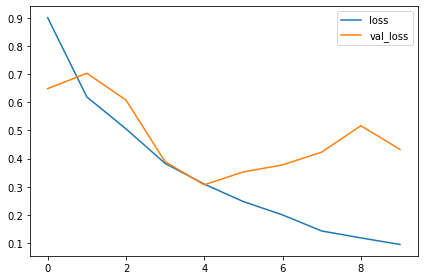

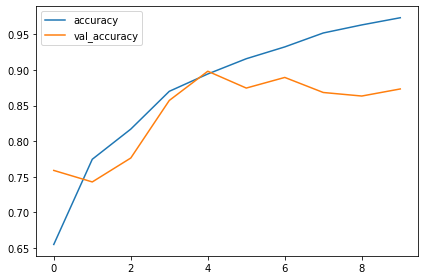

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

This initial model after 5 epochs achieves a validation accuracy of 0.90 with a validation loss of 0.31. After these 5 epochs the validation loss starts to increase and the validation accuracy starts to increase suggesting that the model is overfitting. 

These initial results appear promising as the model required minimal training and had reasonable results.

### 2.3 Pretrained base selection

Three different pretrained bases were used to perform feature extraction as it can be a relatively fast way in imrove the accuracy of a model (Brodzicki et al., 2020). In order to ensure that the weights that have already been learned in training the original models all layers of the pretrained based were set to be non-trainable. The pretrained bases were attached to a simple head and then trained using the training data over 10 epochs to measure which provided the best performance.

In [ ]:
from keras.applications.vgg16 import VGG16
# load model
VGG = VGG16(include_top=False, weights='imagenet', input_shape = (224,224,3))
VGG.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
from keras.applications.inception_v3 import InceptionV3
# load model
inception = InceptionV3(include_top = False, input_shape = (224,224,3) )

inception.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
# load model
efficientnet = EfficientNetB3(include_top = False, weights='imagenet',input_shape = (224,224,3))

efficientnet.trainable = False

43941136/43941136 [==============================] - 2s 0us/step


In [ ]:
def make_model(data = True, graph = True, pretrained_base = inception, epoch = 10):
  """
  Function to train a compiled model incorporating a pretrained_base and a 
  small head. It is compiled using the adam optimiser.

  data: bool - If the history information should be printed, default is true
  graph: bool - If the val_accuracy and val_loss graphs should be printed,
  default is True
  pretrained_base: str - Can be set to any pretrained base, defaults to Inception V3
  epoch: int - number of epochs for the model to run for

  """

  pretrainedbase = pretrained_base
  
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    pretrainedbase,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=epoch,
    verbose = 0
  )
  history_frame = pd.DataFrame(history.history)
  if data == True:
    print(history_frame)
  if graph == True:
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

  return history

       loss  accuracy  val_loss  val_accuracy
0  0.665179  0.789523  0.376854      0.854658
1  0.312376  0.890732  0.384083      0.850932
2  0.242871  0.918940  0.333051      0.879503
3  0.212613  0.922505  0.380613      0.867081
4  0.181274  0.935524  0.505497      0.829814
5  0.145694  0.948078  0.591392      0.802484
6  0.131018  0.953038  0.749585      0.796273
7  0.117804  0.958618  0.655137      0.828571
8  0.100756  0.962957  0.395972      0.891925
9  0.073749  0.975821  0.392144      0.889441


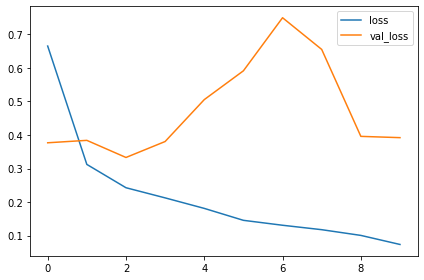

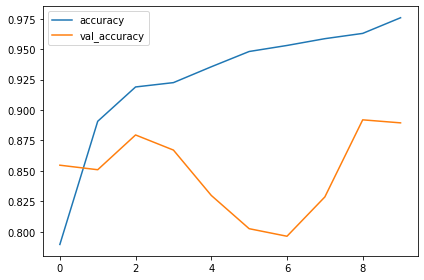

In [ ]:
VGG_history = make_model(pretrained_base = VGG)

       loss  accuracy  val_loss  val_accuracy
0  1.273278  0.825790  0.331743      0.880745
1  0.187978  0.935989  0.250035      0.905590
2  0.133202  0.953813  0.319471      0.896894
3  0.131228  0.952263  0.331310      0.910559
4  0.135562  0.951643  0.447200      0.867081
5  0.078317  0.972102  0.357280      0.900621
6  0.046865  0.983881  0.472048      0.885714
7  0.043653  0.986826  0.563338      0.870807
8  0.041076  0.986206  1.300314      0.778882
9  0.056899  0.979386  0.400497      0.896894


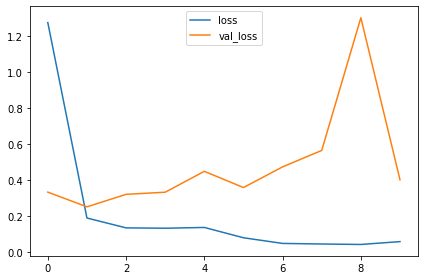

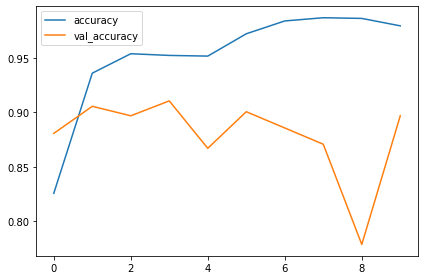

In [ ]:
inception_history = make_model(pretrained_base = inception)

       loss  accuracy  val_loss  val_accuracy
0  4.912604  0.342529  3.595075      0.325466
1  2.226528  0.365933  1.961724      0.329193
2  1.742419  0.372288  2.052036      0.342857
3  1.729481  0.392436  2.097276      0.325466
4  1.447787  0.403286  1.745495      0.325466
5  1.376335  0.404991  1.521471      0.391304
6  1.457168  0.404526  1.189251      0.439752
7  1.349291  0.404216  1.227123      0.380124
8  1.242267  0.433509  1.236171      0.473292
9  1.244033  0.422815  1.219147      0.428571


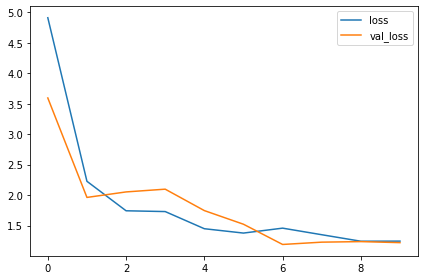

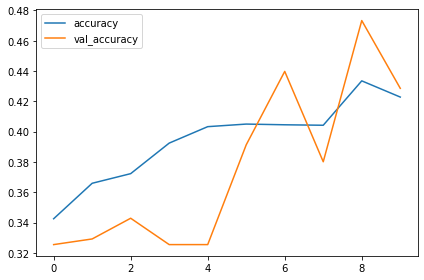

In [ ]:
efficientnet_history = make_model(pretrained_base = efficientnet)

The models used as the pretrained base were EfficientNetB3, Inception V3 and the VGG16. The IncpetionV3 model had the best Val_accuracy and so was selected to be used in all later models. The VGG16 model had equivalent performance to my basic model over this low number of epochs but didn't appear to be overfit so may still have improved its performance. Surprisingly the EfficientNetB3 didn't come close the to accuracy of the baseline model.

 . | Val_loss  | Val_accuracy | Epoch 
-------------------|------------------|-------------------|---------
EfficientNetB3    | 1.17 | 0.53  |8
InceptionV3     | 0.38 | 0.92  | 10
VGG16     | 0.37 | 0.89 | 8


### 2.4 Batch size

All previous models have been tested using a batch size of 32. In order to fine tune this hyperparameter a grid search was performed with a batch size of 2, 4, 8, 16, 32, 64, 128, 256, 512 and 1024
Small batch sizes have been recommended by Wilson & Martinez (2003) for their regularisation effect but Smith (2018) recommends a larger batch size to maximise test performance while minimising the computational time. Larger batch sizes over the same number of epochs as a smaller batch size require less time to run and so less compuational time but they may exceed the computational power of the hardware.

A make_model() function was created in order to allow for repeated models to be created and then a loop ran to measure the validation accurracy and loss as well as the time taken to run 10 epochs.


In [ ]:
batches = [2,4,8,16,32,64,128,256,512,1024] # Set batch sizes to be tested
val_loss = {} # create empty dictionary to save val_loss to
val_accuracy = {} # create empty dictionary to save val_accuracy to
times = {} # create empty dictionary to save time taken to run to

for bs in batches:
  start = time.time() # start timer
  print(bs)
  ds_train_, ds_test_, ds_valid_ = data_size(batch_size = bs) # Create datasets in correct batch size
  history = make_model(False, False) # train model
  end = time.time() # stop timer
  val_accuracy[bs] = round(max(history.history['val_accuracy']),3) # Save best val_accuracy
  val_loss[bs]= round(min(history.history['val_loss']),3) # save best val_loss
  times[bs] = round(end-start) # save time taken to train model 


2
Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
4
Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
8
Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
16
Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
32
Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
64
Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
128
Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
256
Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
512
Found

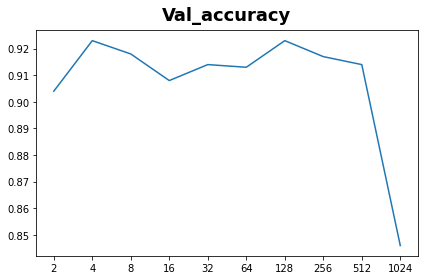

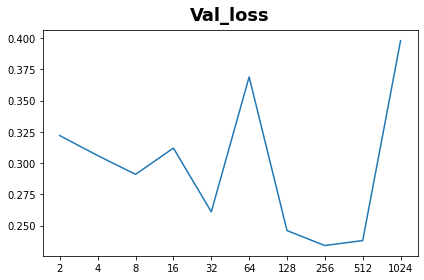

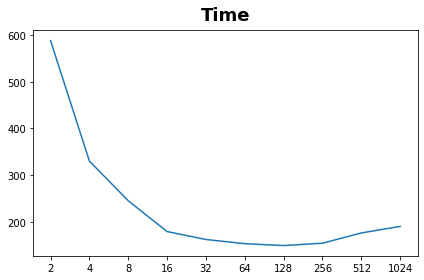

In [ ]:
# Plot val_accuracy 

names = [str(i) for i in (list(val_accuracy.keys()))] # create vector of batch size tested
values = list(val_accuracy.values()) # create vector of val_accuracy values

plt.plot( names, values) # create plot of val_accuracy
plt.title('Val_accuracy')
plt.show()

# Plot val_loss

names = [str(i) for i in (list(val_loss.keys()))] # create vector of batch size tested
values = list(val_loss.values()) # create vector of val_loss values

plt.plot( names, values) # create plot
plt.title('Val_loss')
plt.show()

# Plot Time taken
names = [str(i) for i in (list(times.keys()))] #  create vector of batch size tested
values = list(times.values()) # create vector of time values

plt.plot( names, values) # Create plot
plt.title('Time')
plt.show()

A batch size of 128 was selected for inclusion in the final model using this data as it had the joint highest validation accuracy, the 3rd lowest validation loss and the shortest time. A new model was created using this batch size over 10 epochs to create a new baseline.

In [ ]:
val_accuracy

{2: 0.904,
 4: 0.923,
 8: 0.918,
 16: 0.908,
 32: 0.914,
 64: 0.913,
 128: 0.923,
 256: 0.917,
 512: 0.914,
 1024: 0.846}

In [ ]:
val_loss

{2: 0.322,
 4: 0.306,
 8: 0.291,
 16: 0.312,
 32: 0.261,
 64: 0.369,
 128: 0.246,
 256: 0.234,
 512: 0.238,
 1024: 0.398}

In [ ]:
times

{2: 588,
 4: 330,
 8: 245,
 16: 179,
 32: 162,
 64: 153,
 128: 149,
 256: 154,
 512: 176,
 1024: 190}

chicken-disease-1 .zip: Skipping, found more recently modified local copy (use --force to force download)
cocci 2476
healthy 2404
ncd 562
salmonella 2625


Copying files: 8067 files [00:01, 5420.95 files/s]


Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.
       loss  accuracy  val_loss  val_accuracy
0  3.920146  0.730626  0.375218      0.880745
1  0.295861  0.911345  0.268436      0.905590
2  0.158003  0.951953  0.306642      0.888199
3  0.120116  0.961562  0.296866      0.898137
4  0.130813  0.952263  0.243057      0.919255
5  0.182647  0.930719  0.648914      0.816149
6  0.168859  0.941104  0.489795      0.843478
7  0.139723  0.951488  0.366218      0.909317
8  0.106204  0.961407  0.281849      0.929193
9  0.042846  0.985276  0.341563      0.910559


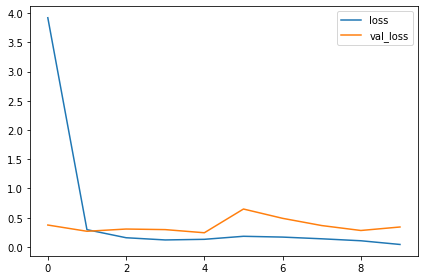

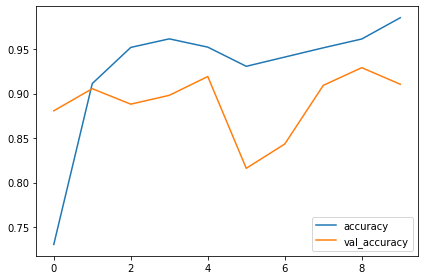

In [ ]:
## model for future comparison
get_data()
ds_train_, ds_test_, ds_valid_ = data_size(batch_size = 128) # using the optimum batch size
history = make_model()

The effect of batch size on the validation data accuracy appeared to increase and validation loss decrease upto a batch size of 128. This batch size was also the quickest to run 10 epochs and so was chosen for inclusion in the final model.

### 2.5 Data Augmentation

Data augmentation involves adding random transformations to the data before it is input into the model. This step helps to avoid overfitting to the data and is especially useful with smaller datasets such as this one (Mikołajczyk and Grochowski, 2018). The augmentations included were RandomFlip (both horizonal and vertical), RandomZoon, RandomRotation and RandomTranslation.

In [ ]:
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomZoom(0.2),
        layers.RandomRotation(factor = 0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ])

In [ ]:
def make_model(data = True, graph = True, pretrained_base = inception, epoch = 10, augmentation = False):
  """
  Function to train a compiled model incorporating a pretrained_base and a 
  small head. It is compiled using the adam optimiser.

  data: bool - If the history information should be printed, default is true
  graph: bool - If the val_accuracy and val_loss graphs should be printed,
  default is True
  pretrained_base: str - Can be set to any pretrained base, defaults to Inception V3
  epoch: int - number of epochs for the model to run for

  """

  pretrainedbase = pretrained_base

  if augmentation == False:
    model = keras.Sequential([
      tf.keras.layers.Rescaling(1./255),
      pretrainedbase,
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(4, activation='softmax'),
    ])

  elif augmentation == True:
    model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    pretrained_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
    
  else:
    print("Invalid arguement for augmentation. \n 'True' or 'False' are only valid values")
    
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=epoch,
    verbose = 0
  )
  history_frame = pd.DataFrame(history.history)
  if data == True:
    print(history_frame)
  if graph == True:
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

  return history

chicken-disease-1 .zip: Skipping, found more recently modified local copy (use --force to force download)
cocci 2476
healthy 2404
ncd 562
salmonella 2625


Copying files: 8067 files [00:01, 4189.44 files/s]


Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.


       loss  accuracy  val_loss  val_accuracy
0  8.555355  0.659020  0.530581      0.829814
1  0.429518  0.854774  0.478416      0.816149
2  0.358610  0.873373  0.434734      0.826087
3  0.338830  0.884377  0.343760      0.870807
4  0.308733  0.890732  0.317006      0.893168
5  0.289921  0.899721  0.290590      0.895652
6  0.273393  0.904371  0.333099      0.879503
7  0.262371  0.906231  0.300830      0.889441
8  0.261608  0.909020  0.293083      0.899379
9  0.255648  0.913205  0.293351      0.896894


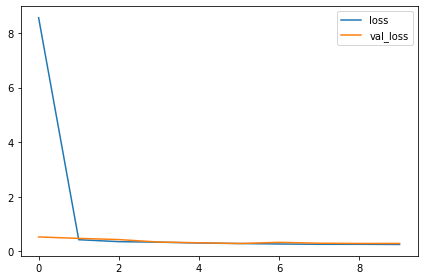

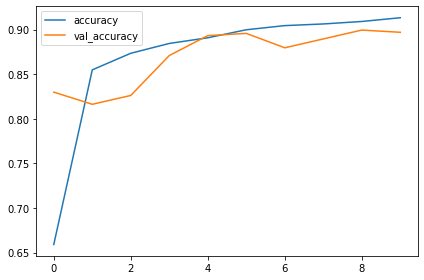

In [ ]:
get_data()
ds_train_, ds_test_, ds_valid_ = data_size()
aug_history = make_model(augmentation = True)

Validation accuracy was slighly worse with the augmented data but the validation loss was improved. The loss and accuracy didn't appear to plateau so further epochs may have continued to improve performance. For this reason augmentation was included in the final model.

### 2.6 Head shape

The model head so far has been

```
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4, activation='softmax'),
```
In order to determine if an alternate head shape could improve model performance wider and deeper heads were used to train the model.


In [ ]:
def deep_model():
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 0
  )
  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();


       loss  accuracy  val_loss  val_accuracy
0  1.750568  0.705363  0.375966      0.844720
1  0.381499  0.862213  0.384420      0.853416
2  0.341724  0.881432  0.344224      0.878261
3  0.308616  0.886857  0.263023      0.911801
4  0.273670  0.903906  0.274467      0.901863
5  0.249649  0.912275  0.270982      0.895652
6  0.270930  0.903906  0.264081      0.905590
7  0.249042  0.910105  0.257566      0.903106
8  0.269356  0.903131  0.277661      0.893168
9  0.242720  0.913980  0.295225      0.881988


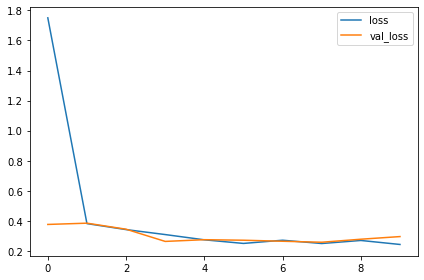

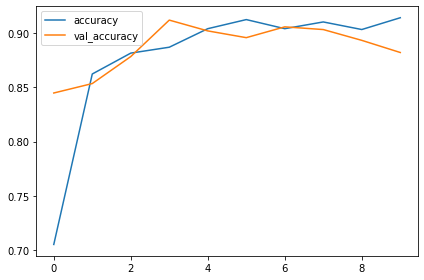

In [ ]:
deep_model()

In [ ]:
def wide_model():
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 0
  )
  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();


        loss  accuracy  val_loss  val_accuracy
0  14.752527  0.627247  0.558815      0.772671
1   0.384402  0.865003  0.383495      0.847205
2   0.349139  0.877867  0.393988      0.852174
3   0.317505  0.888717  0.268685      0.900621
4   0.256662  0.906696  0.258872      0.904348
5   0.276922  0.901581  0.304901      0.885714
6   0.263111  0.904526  0.303378      0.880745
7   0.247839  0.912430  0.291691      0.886957
8   0.234529  0.917390  0.263400      0.895652
9   0.240369  0.915995  0.285119      0.888199


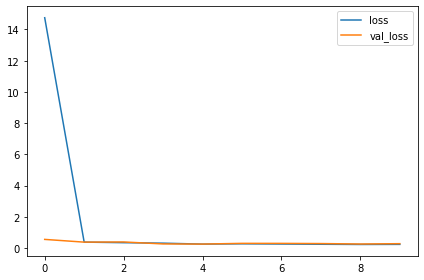

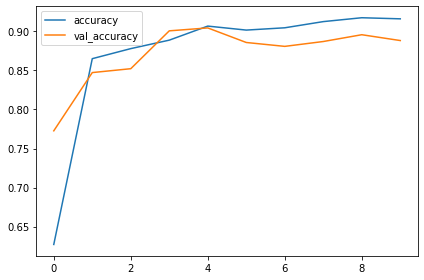

In [ ]:
wide_model()

In [ ]:
def wide_deep_model():
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 0
  )
  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();


       loss  accuracy  val_loss  val_accuracy
0  4.492121  0.658400  0.522119      0.775155
1  0.367049  0.863298  0.303571      0.890683
2  0.324999  0.889957  0.350699      0.872050
3  0.292107  0.895691  0.313120      0.888199
4  0.281525  0.902511  0.268332      0.898137
5  0.278363  0.901426  0.287554      0.906832
6  0.259408  0.910725  0.346783      0.868323
7  0.253944  0.905611  0.281733      0.899379
8  0.237565  0.917545  0.289921      0.885714
9  0.240840  0.910880  0.291676      0.889441


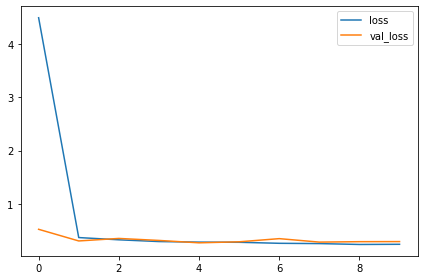

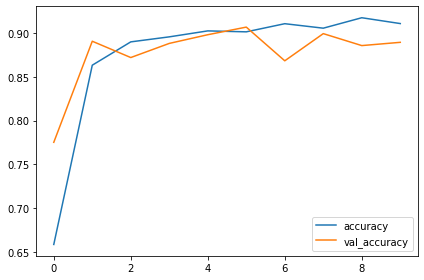

In [ ]:
wide_deep_model()

In [ ]:
def wide_deep_dropout_model():
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 0
  )
  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

       loss  accuracy  val_loss  val_accuracy
0  3.421988  0.609733  0.523241      0.788820
1  0.512284  0.811996  0.394152      0.850932
2  0.440329  0.840980  0.358710      0.862112
3  0.399920  0.857254  0.332215      0.878261
4  0.377248  0.869343  0.315508      0.891925
5  0.358186  0.877247  0.322299      0.898137
6  0.353802  0.878022  0.318243      0.894410
7  0.336886  0.883912  0.357444      0.870807
8  0.359498  0.874923  0.285987      0.911801
9  0.334399  0.886547  0.332613      0.891925


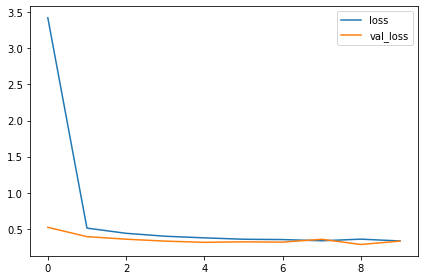

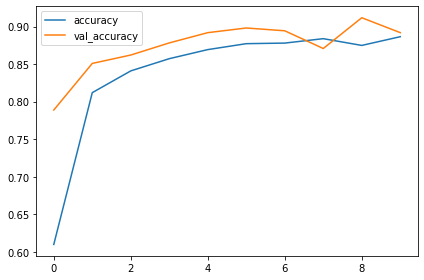

In [ ]:
wide_deep_dropout_model()

In [ ]:
# testing original head with dropout.
def dropout_model():
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax'),
  ])
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )

  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    epochs=10,
    verbose = 1
  )
  history_frame = pd.DataFrame(history.history)
  print(history_frame)
  history_frame.loc[:, ['loss', 'val_loss']].plot()
  history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

Epoch 1/10


51/51 [==============================] - 76s 1s/step - loss: 3.7189 - accuracy: 0.6224 - val_loss: 0.5669 - val_accuracy: 0.8099
Epoch 2/10
51/51 [==============================] - 66s 1s/step - loss: 0.5980 - accuracy: 0.7588 - val_loss: 0.3892 - val_accuracy: 0.8534
Epoch 3/10
51/51 [==============================] - 66s 1s/step - loss: 0.4963 - accuracy: 0.8064 - val_loss: 0.3793 - val_accuracy: 0.8596
Epoch 4/10
51/51 [==============================] - 66s 1s/step - loss: 0.4873 - accuracy: 0.8070 - val_loss: 0.3396 - val_accuracy: 0.8820
Epoch 5/10
51/51 [==============================] - 65s 1s/step - loss: 0.4518 - accuracy: 0.8179 - val_loss: 0.3431 - val_accuracy: 0.8832
Epoch 6/10
51/51 [==============================] - 66s 1s/step - loss: 0.4317 - accuracy: 0.8253 - val_loss: 0.3129 - val_accuracy: 0.8870
Epoch 7/10
51/51 [==============================] - 65s 1s/step - loss: 0.4132 - accuracy: 0.8315 - val_loss: 0.2950 - val_accuracy: 0.8919
Epoch 8/10
51/51 [=============

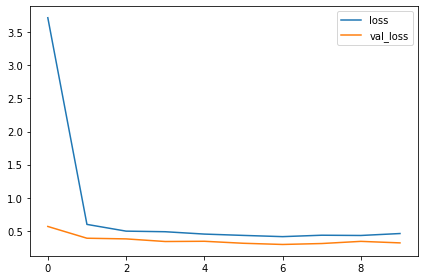

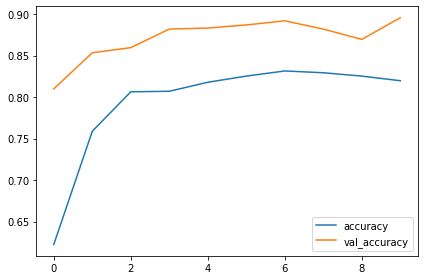

In [ ]:
dropout_model()

 . | Val_loss  | Val_accuracy 
-------------------|------------------|------------------
Original head   | 0.293 | 0.899 
Original head with dropout | 0.295 | 0.896
Wide Head    | 0.259 | 0.904  
Deep Head    | 0.263 | 0.912 
Wide & Deep Head | 0.286  | 0.907 
Wide & Deep with Dropout | 0.276 | 0.912 


All of the alternative heads performed better than the original simple head. The wide and deep head shown below had the best performance as measured by Validation accuracy and so it was selected for use in the final model.



```
model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
```




### 2.7 Callbacks

An early stopping callback was included in the final model so as to reduce the potential for overfitting. It does this by monitoring an output, in this case validation accuracy, and stopping the training once the model stops improving.

A model saving checkpoint is also included so as to save the best performing model created during training.

Should i include reduce learning rate on plateau???

In [ ]:
checkpoint_filepath = '/content/Models'
callback = [
    callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    monitor = 'val_accuracy',
    verbose = 1
),
callbacks.ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', verbose = 1, factor = 0.5),
]

In [ ]:
def final_model(data = True, graph = True, epoch = 200, verbose = 1, fine_tune = 0 ):
  """
  Function to train a compiled model incorporating a pretrained_base and a 
  head. It is compiled using the adam optimiser.

  data: bool - If the history information should be printed, default is true
  graph: bool - If the val_accuracy and val_loss graphs should be printed,
  default is True
  epoch: int - number of epochs for the model to run for
  verbose: int - 1 for show progress, 0 for don't show progress
  fine_tune: int - layers of the convolutional base to be trainable

  """
  tf.get_logger().setLevel('ERROR')
  # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
  conv_base = InceptionV3(include_top = False, input_shape = (224,224,3) )
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.

  if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
  else:
        for layer in conv_base.layers:
            layer.trainable = False


  ## define the model including, augemntation, and trainable base
  model = keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    inception,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax'),
  ])
    
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
  )
  history = model.fit(
    ds_train_,
    validation_data=ds_valid_,
    callbacks = [callback],
    epochs=epoch,
    verbose = verbose)
  
  history_frame = pd.DataFrame(history.history)
  if data == True:
    print(history_frame)
  if graph == True:
    history_frame.loc[1:, ['loss', 'val_loss']].plot()
    history_frame.loc[1:, ['accuracy', 'val_accuracy']].plot();

  return history



### 2.8 Equal data sizes - To move to last thing

It is recognised that ensuring an equal spread of data within each category is important as conventional classifiers have been designed to work with equal data classes and so optimal results are not normally achieved in underrepresented classes (Villoria et al, 2020).

In order to attempt to measure the impact uneven data classes in this dataset, all categories were limited to a maximum size of the smallest original category (Newcastle Disease, n= 562) and the model trained on this data.


In [ ]:
def get_even_data():
  !rm -rf /content/Train
  !rm -rf /content/train_data.csv

  !kaggle datasets download -d 'allandclive/chicken-disease-1 ' -p /content #download data
  !unzip -qq 'chicken-disease-1 .zip' # unzip data
  

  folder_path = '/content/Train' # Set path where images are
# create list of images to go through below
  images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

  for image in images:
    folder_name = image.split('.')[0] # Creates folder based on first part of name

    new_path = os.path.join(folder_path, folder_name) # creates new path name
    if not os.path.exists(new_path): # checks if path exixts
      os.makedirs(new_path)  # if doesn't exists creates it

    old_image_path = os.path.join(folder_path, image)
    new_image_path = os.path.join(new_path, image)
    shutil.move(old_image_path, new_image_path) # moves picture
    
  # merge all folders with similar contents

  mergefolders('/content/Train/pcrcocci', '/content/Train/cocci')
  mergefolders('/content/Train/pcrsalmo', '/content/Train/salmo')
  mergefolders('/content/Train/pcrncd', '/content/Train/ncd')
  mergefolders('/content/Train/pcrhealthy', '/content/Train/healthy')

  # remove folders not needed

  !rm -rf '/content/Train/pcrsalmo'
  !rm -rf '/content/Train/pcrncd'
  !rm -rf '/content/Train/pcrhealthy'                    
  !rm -rf '/content/Train/pcrcocci'

  # Check folder counts
  print("Initial Folder counts \n ")
  print(f"cocci {len(os.listdir('/content/Train/cocci'))}")
  print(f"healthy {len(os.listdir('/content/Train/healthy'))}")
  print(f"ncd {len(os.listdir('/content/Train/ncd'))}")
  print(f"salmonella {len(os.listdir('/content/Train/salmo'))}")

  def equal_size(path, length = 562):
    # path = '/content/Train/cocci'
    i = 0 
    for pic in os.listdir(path):
      if i >= length:
        pic_path = os.path.join(path, pic)
        os.remove(pic_path)
      i += 1
      path_name = path.split('/')
    print(f"{path_name[3]} {len(os.listdir(path))}")
  print("")
  
  print("Equalised folder counts \n ")  
  equal_size('/content/Train/cocci')
  equal_size('/content/Train/healthy')
  equal_size('/content/Train/ncd')
  equal_size('/content/Train/salmo')

  print("")
  !rm -rf  /content/output # remove previous split data
  print("Split folder counts \n")
  splitfolders.ratio('Train', output="output", seed=1337, ratio=(.8, 0.1,0.1)) # split the data
 

This even split of data was then used to train a model to compare to the currently best optimised model which has a validation accuracy of 0.92 and a validation loss of 0.26. The model trained using the even category sizes achieved a validation accuracy of 0.94 and a validation loss of 0.27. Based on this evidence a decision was made to use the even catgegory size dataset.

In [ ]:
get_even_data()
ds_train_, ds_test_, ds_valid_ = data_size()


chicken-disease-1 .zip: Skipping, found more recently modified local copy (use --force to force download)
Initial Folder counts 
 
cocci 2476
healthy 2404
ncd 562
salmonella 2625

Equalised folder counts 
 
cocci 562
healthy 562
ncd 562
salmo 562

Split folder counts 



Copying files: 2248 files [00:00, 5935.01 files/s]


Found 1796 files belonging to 4 classes.
Found 224 files belonging to 4 classes.
Found 228 files belonging to 4 classes.


Epoch 1/200
15/15 [==============================] - ETA: 0s - loss: 2.3909 - accuracy: 0.3285
Epoch 1: val_accuracy did not improve from 0.92795
15/15 [==============================] - 34s 2s/step - loss: 2.3909 - accuracy: 0.3285 - val_loss: 1.1987 - val_accuracy: 0.5580 - lr: 0.0010
Epoch 2/200
14/15 [===========================>..] - ETA: 1s - loss: 0.7810 - accuracy: 0.6914
Epoch 2: val_accuracy did not improve from 0.92795
15/15 [==============================] - 19s 1s/step - loss: 0.7796 - accuracy: 0.6921 - val_loss: 0.9459 - val_accuracy: 0.7054 - lr: 0.0010
Epoch 3/200
14/15 [===========================>..] - ETA: 1s - loss: 0.5724 - accuracy: 0.7902
Epoch 3: val_accuracy did not improve from 0.92795
15/15 [==============================] - 22s 1s/step - loss: 0.5718 - accuracy: 0.7901 - val_loss: 0.6089 - val_accuracy: 0.7946 - lr: 0.0010
Epoch 4/200
14/15 [===========================>..] - ETA: 1s - loss: 0.4758 - accuracy: 0.8209
Epoch 4: val_accuracy did not improve fro

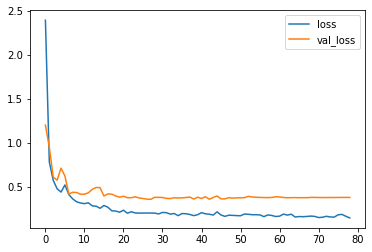

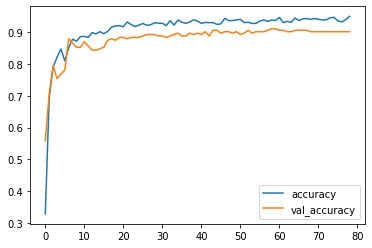

In [ ]:
final_model()

### 2.9 Fine tuning the model


In [ ]:
get_data()
ds_train_, ds_test_, ds_valid_ = data_size()

chicken-disease-1 .zip: Skipping, found more recently modified local copy (use --force to force download)
cocci 2476
healthy 2404
ncd 562
salmonella 2625


Copying files: 8067 files [00:01, 6883.34 files/s]


Found 6452 files belonging to 4 classes.
Found 805 files belonging to 4 classes.
Found 810 files belonging to 4 classes.



Epoch 1: val_accuracy improved from -inf to 0.84596, saving model to /content/Models



Epoch 2: val_accuracy improved from 0.84596 to 0.86708, saving model to /content/Models



Epoch 3: val_accuracy improved from 0.86708 to 0.89068, saving model to /content/Models



Epoch 4: val_accuracy did not improve from 0.89068

Epoch 5: val_accuracy improved from 0.89068 to 0.90559, saving model to /content/Models



Epoch 6: val_accuracy did not improve from 0.90559

Epoch 7: val_accuracy did not improve from 0.90559

Epoch 8: val_accuracy improved from 0.90559 to 0.91056, saving model to /content/Models



Epoch 9: val_accuracy improved from 0.91056 to 0.91801, saving model to /content/Models



Epoch 10: val_accuracy did not improve from 0.91801

Epoch 11: val_accuracy did not improve from 0.91801

Epoch 12: val_accuracy did not improve from 0.91801

Epoch 13: val_accuracy did not improve from 0.91801

Epoch 14: val_accuracy did not improve from 0.91801

Epoch 15: val_accuracy did not improve from 0.91801

Epoch 16: val_accuracy improved from 0.91801 to 0.92547, saving model to /content/Models



Epoch 17: val_accuracy did not improve from 0.92547

Epoch 18: val_accuracy improved from 0.92547 to 0.92671, saving model to /content/Models



Epoch 19: val_accuracy did not improve from 0.92671

Epoch 20: val_accuracy did not improve from 0.92671

Epoch 21: val_accuracy did not improve from 0.92671

Epoch 22: val_accuracy did not improve from 0.92671

Epoch 23: val_accuracy did not improve from 0.92671

Epoch 24: val_accuracy did not improve from 0.92671

Epoch 25: val_accuracy did not improve from 0.92671

Epoch 26: val_accuracy did not improve from 0.92671

Epoch 27: val_accuracy did not improve from 0.92671

Epoch 28: val_accuracy did not improve from 0.92671

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: val_accuracy did not improve from 0.92671

Epoch 30: val_accuracy did not improve from 0.92671

Epoch 31: val_accuracy improved from 0.92671 to 0.92795, saving model to /content/Models



Epoch 32: val_accuracy did not improve from 0.92795

Epoch 33: val_accuracy improved from 0.92795 to 0.93168, saving model to /content/Models



Epoch 34: val_accuracy did not improve from 0.93168

Epoch 35: val_accuracy did not improve from 0.93168

Epoch 36: val_accuracy did not improve from 0.93168

Epoch 37: val_accuracy did not improve from 0.93168

Epoch 38: val_accuracy did not improve from 0.93168

Epoch 39: val_accuracy did not improve from 0.93168

Epoch 40: val_accuracy did not improve from 0.93168

Epoch 41: val_accuracy did not improve from 0.93168

Epoch 42: val_accuracy did not improve from 0.93168

Epoch 43: val_accuracy did not improve from 0.93168

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: val_accuracy did not improve from 0.93168

Epoch 45: val_accuracy did not improve from 0.93168

Epoch 46: val_accuracy did not improve from 0.93168

Epoch 47: val_accuracy did not improve from 0.93168

Epoch 48: val_accuracy improved from 0.93168 to 0.93292, saving model to /content/Models



Epoch 49: val_accuracy did not improve from 0.93292

Epoch 50: val_accuracy did not improve from 0.93292

Epoch 51: val_accuracy improved from 0.93292 to 0.93416, saving model to /content/Models



Epoch 52: val_accuracy did not improve from 0.93416

Epoch 53: val_accuracy did not improve from 0.93416

Epoch 54: val_accuracy did not improve from 0.93416

Epoch 55: val_accuracy did not improve from 0.93416

Epoch 56: val_accuracy improved from 0.93416 to 0.93665, saving model to /content/Models



Epoch 57: val_accuracy did not improve from 0.93665

Epoch 58: val_accuracy did not improve from 0.93665

Epoch 59: val_accuracy did not improve from 0.93665

Epoch 60: val_accuracy did not improve from 0.93665

Epoch 61: val_accuracy did not improve from 0.93665

Epoch 62: val_accuracy did not improve from 0.93665

Epoch 63: val_accuracy did not improve from 0.93665

Epoch 64: val_accuracy did not improve from 0.93665

Epoch 65: val_accuracy did not improve from 0.93665

Epoch 66: val_accuracy improved from 0.93665 to 0.93913, saving model to /content/Models



Epoch 67: val_accuracy did not improve from 0.93913

Epoch 68: val_accuracy did not improve from 0.93913

Epoch 69: val_accuracy did not improve from 0.93913

Epoch 70: val_accuracy did not improve from 0.93913

Epoch 71: val_accuracy did not improve from 0.93913

Epoch 72: val_accuracy did not improve from 0.93913

Epoch 73: val_accuracy did not improve from 0.93913

Epoch 74: val_accuracy did not improve from 0.93913

Epoch 75: val_accuracy did not improve from 0.93913

Epoch 76: val_accuracy did not improve from 0.93913

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 77: val_accuracy did not improve from 0.93913

Epoch 78: val_accuracy did not improve from 0.93913

Epoch 79: val_accuracy did not improve from 0.93913

Epoch 80: val_accuracy did not improve from 0.93913

Epoch 81: val_accuracy did not improve from 0.93913

Epoch 82: val_accuracy did not improve from 0.93913

Epoch 83: val_accuracy did not improve from 0.93913

Epoch 84: val_accura

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

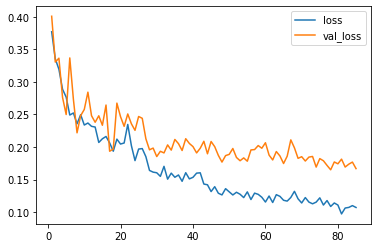

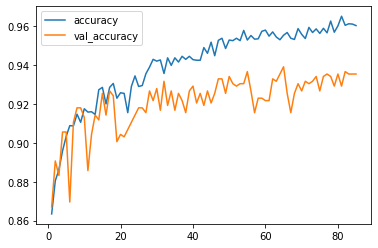

In [ ]:
history1 = final_model(fine_tune = 0, data = False, verbose = False)
print(f"Best Validation accuracy: {round(max(history1.history['val_accuracy']),3)}") #print best validation accuracy
print(f"Best Validation loss: {round(min(history1.history['val_loss']),3)}")  # print best validation loss
history_frame = pd.DataFrame(history1.history)
history_frame.to_csv(('fine_tune0.csv'))
files.download('fine_tune0.csv')



Epoch 1: val_accuracy did not improve from 0.93913

Epoch 2: val_accuracy did not improve from 0.93913

Epoch 3: val_accuracy did not improve from 0.93913

Epoch 4: val_accuracy did not improve from 0.93913

Epoch 5: val_accuracy did not improve from 0.93913

Epoch 6: val_accuracy did not improve from 0.93913

Epoch 7: val_accuracy did not improve from 0.93913

Epoch 8: val_accuracy did not improve from 0.93913

Epoch 9: val_accuracy did not improve from 0.93913

Epoch 10: val_accuracy did not improve from 0.93913

Epoch 11: val_accuracy did not improve from 0.93913

Epoch 12: val_accuracy did not improve from 0.93913

Epoch 13: val_accuracy did not improve from 0.93913

Epoch 14: val_accuracy did not improve from 0.93913

Epoch 15: val_accuracy did not improve from 0.93913

Epoch 16: val_accuracy did not improve from 0.93913

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 17: val_accuracy did not improve from 0.93913

Epoch 18: val_accuracy did no

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

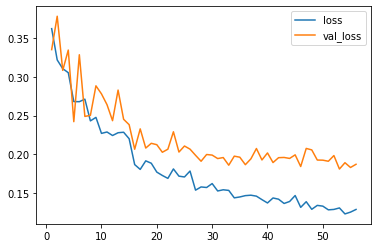

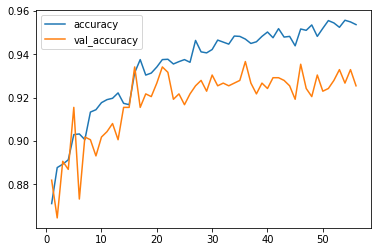

In [ ]:
history2 = final_model(fine_tune = 20, data = False, verbose = False)
print(f"Best Validation accuracy: {round(max(history2.history['val_accuracy']),3)}") #print best validation accuracy
print(f"Best Validation loss: {round(min(history2.history['val_loss']),3)}")  # print best validation loss
history_frame = pd.DataFrame(history2.history)
history_frame.to_csv(('fine_tune20.csv'))
files.download('fine_tune20.csv')

Epoch 1/200
202/202 [==============================] - ETA: 0s - loss: 0.8106 - accuracy: 0.7829
Epoch 1: val_accuracy improved from -inf to 0.87205, saving model to /content/Models


202/202 [==============================] - 83s 327ms/step - loss: 0.8106 - accuracy: 0.7829 - val_loss: 0.3639 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 2/200
202/202 [==============================] - ETA: 0s - loss: 0.3816 - accuracy: 0.8695
Epoch 2: val_accuracy improved from 0.87205 to 0.89441, saving model to /content/Models


202/202 [==============================] - 62s 309ms/step - loss: 0.3816 - accuracy: 0.8695 - val_loss: 0.3163 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 3/200
202/202 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.8797
Epoch 3: val_accuracy improved from 0.89441 to 0.89565, saving model to /content/Models


202/202 [==============================] - 62s 308ms/step - loss: 0.3416 - accuracy: 0.8797 - val_loss: 0.3098 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 4/200
202/202 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8890
Epoch 4: val_accuracy did not improve from 0.89565
202/202 [==============================] - 26s 127ms/step - loss: 0.3130 - accuracy: 0.8890 - val_loss: 0.3616 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 5/200
202/202 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8912
Epoch 5: val_accuracy did not improve from 0.89565
202/202 [==============================] - 26s 127ms/step - loss: 0.3111 - accuracy: 0.8912 - val_loss: 0.3634 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 6/200
202/202 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.8971
Epoch 6: val_accuracy did not improve from 0.89565
202/202 [==============================] - 25s 126ms/step - loss: 0.2882 - accuracy: 0.8971 - val_loss: 0.3471 - va

202/202 [==============================] - 62s 308ms/step - loss: 0.2881 - accuracy: 0.9030 - val_loss: 0.2676 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 8/200
202/202 [==============================] - ETA: 0s - loss: 0.2680 - accuracy: 0.9058
Epoch 8: val_accuracy did not improve from 0.90311
202/202 [==============================] - 26s 127ms/step - loss: 0.2680 - accuracy: 0.9058 - val_loss: 0.2898 - val_accuracy: 0.8932 - lr: 0.0010
Epoch 9/200
202/202 [==============================] - ETA: 0s - loss: 0.2733 - accuracy: 0.9042
Epoch 9: val_accuracy did not improve from 0.90311
202/202 [==============================] - 26s 126ms/step - loss: 0.2733 - accuracy: 0.9042 - val_loss: 0.2906 - val_accuracy: 0.8981 - lr: 0.0010
Epoch 10/200
202/202 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.9044
Epoch 10: val_accuracy did not improve from 0.90311
202/202 [==============================] - 26s 127ms/step - loss: 0.2661 - accuracy: 0.9044 - val_loss: 0.2676 - 

202/202 [==============================] - 63s 312ms/step - loss: 0.2612 - accuracy: 0.9045 - val_loss: 0.2533 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 12/200
202/202 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.9064
Epoch 12: val_accuracy did not improve from 0.91429
202/202 [==============================] - 26s 127ms/step - loss: 0.2551 - accuracy: 0.9064 - val_loss: 0.2441 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 13/200
202/202 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9154
Epoch 13: val_accuracy did not improve from 0.91429
202/202 [==============================] - 26s 126ms/step - loss: 0.2376 - accuracy: 0.9154 - val_loss: 0.2715 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 14/200
202/202 [==============================] - ETA: 0s - loss: 0.2525 - accuracy: 0.9115
Epoch 14: val_accuracy improved from 0.91429 to 0.92422, saving model to /content/Models


202/202 [==============================] - 63s 310ms/step - loss: 0.2525 - accuracy: 0.9115 - val_loss: 0.2188 - val_accuracy: 0.9242 - lr: 0.0010
Epoch 15/200
202/202 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9185
Epoch 15: val_accuracy did not improve from 0.92422
202/202 [==============================] - 26s 127ms/step - loss: 0.2244 - accuracy: 0.9185 - val_loss: 0.2919 - val_accuracy: 0.8907 - lr: 0.0010
Epoch 16/200
202/202 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9169
Epoch 16: val_accuracy did not improve from 0.92422
202/202 [==============================] - 26s 127ms/step - loss: 0.2424 - accuracy: 0.9169 - val_loss: 0.2671 - val_accuracy: 0.9056 - lr: 0.0010
Epoch 17/200
202/202 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9134
Epoch 17: val_accuracy did not improve from 0.92422
202/202 [==============================] - 26s 127ms/step - loss: 0.2354 - accuracy: 0.9134 - val_loss: 0.238

202/202 [==============================] - 62s 308ms/step - loss: 0.1915 - accuracy: 0.9320 - val_loss: 0.2046 - val_accuracy: 0.9255 - lr: 5.0000e-04
Epoch 28/200
202/202 [==============================] - ETA: 0s - loss: 0.1806 - accuracy: 0.9351
Epoch 28: val_accuracy did not improve from 0.92547
202/202 [==============================] - 26s 127ms/step - loss: 0.1806 - accuracy: 0.9351 - val_loss: 0.1959 - val_accuracy: 0.9255 - lr: 5.0000e-04
Epoch 29/200
202/202 [==============================] - ETA: 0s - loss: 0.1858 - accuracy: 0.9330
Epoch 29: val_accuracy did not improve from 0.92547
202/202 [==============================] - 26s 126ms/step - loss: 0.1858 - accuracy: 0.9330 - val_loss: 0.2017 - val_accuracy: 0.9230 - lr: 5.0000e-04
Epoch 30/200
202/202 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9372
Epoch 30: val_accuracy did not improve from 0.92547
202/202 [==============================] - 25s 126ms/step - loss: 0.1750 - accuracy: 0.9372 - val

202/202 [==============================] - 62s 310ms/step - loss: 0.1639 - accuracy: 0.9406 - val_loss: 0.1892 - val_accuracy: 0.9329 - lr: 5.0000e-04
Epoch 38/200
202/202 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9405
Epoch 38: val_accuracy did not improve from 0.93292
202/202 [==============================] - 26s 127ms/step - loss: 0.1556 - accuracy: 0.9405 - val_loss: 0.1991 - val_accuracy: 0.9267 - lr: 5.0000e-04
Epoch 39/200
202/202 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9391
Epoch 39: val_accuracy did not improve from 0.93292
202/202 [==============================] - 26s 126ms/step - loss: 0.1702 - accuracy: 0.9391 - val_loss: 0.2180 - val_accuracy: 0.9143 - lr: 5.0000e-04
Epoch 40/200
202/202 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9378
Epoch 40: val_accuracy did not improve from 0.93292
202/202 [==============================] - 26s 126ms/step - loss: 0.1690 - accuracy: 0.9378 - val

202/202 [==============================] - 62s 308ms/step - loss: 0.1406 - accuracy: 0.9506 - val_loss: 0.1748 - val_accuracy: 0.9366 - lr: 2.5000e-04
Epoch 51/200
202/202 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9526
Epoch 51: val_accuracy did not improve from 0.93665
202/202 [==============================] - 26s 126ms/step - loss: 0.1347 - accuracy: 0.9526 - val_loss: 0.1788 - val_accuracy: 0.9304 - lr: 2.5000e-04
Epoch 52/200
202/202 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9495
Epoch 52: val_accuracy did not improve from 0.93665
202/202 [==============================] - 26s 127ms/step - loss: 0.1329 - accuracy: 0.9495 - val_loss: 0.1866 - val_accuracy: 0.9280 - lr: 2.5000e-04
Epoch 53/200
202/202 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9465
Epoch 53: val_accuracy did not improve from 0.93665
202/202 [==============================] - 26s 127ms/step - loss: 0.1449 - accuracy: 0.9465 - val

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

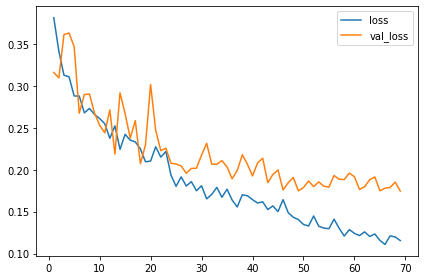

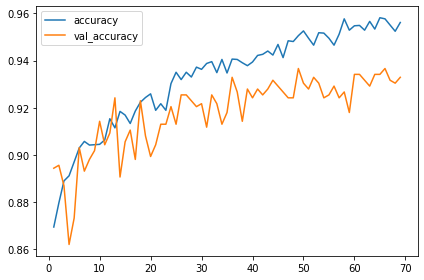

In [ ]:
history3 = final_model(fine_tune = 40, data = False, verbose = True)
print(f"Best Validation accuracy: {round(max(history3.history['val_accuracy']),3)}") #print best validation accuracy
print(f"Best Validation loss: {round(min(history3.history['val_loss']),3)}")  # print best validation loss
history_frame = pd.DataFrame(history3.history)
history_frame.to_csv(('fine_tune40.csv'))
files.download('fine_tune40.csv')

Epoch 1/200
51/51 [==============================] - ETA: 0s - loss: 1.7243 - accuracy: 0.6775
Epoch 1: val_accuracy did not improve from 0.92671
51/51 [==============================] - 60s 1s/step - loss: 1.7243 - accuracy: 0.6775 - val_loss: 0.6278 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 2/200
51/51 [==============================] - ETA: 0s - loss: 0.4413 - accuracy: 0.8464
Epoch 2: val_accuracy did not improve from 0.92671
51/51 [==============================] - 51s 1s/step - loss: 0.4413 - accuracy: 0.8464 - val_loss: 0.3304 - val_accuracy: 0.8795 - lr: 0.0010
Epoch 3/200
51/51 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8808
Epoch 3: val_accuracy did not improve from 0.92671
51/51 [==============================] - 51s 994ms/step - loss: 0.3352 - accuracy: 0.8808 - val_loss: 0.4006 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/200
51/51 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8839
Epoch 4: val_accuracy did not improve 

51/51 [==============================] - 88s 2s/step - loss: 0.1744 - accuracy: 0.9388 - val_loss: 0.1990 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 38/200
51/51 [==============================] - ETA: 0s - loss: 0.1733 - accuracy: 0.9375
Epoch 38: val_accuracy did not improve from 0.92919
51/51 [==============================] - 51s 1s/step - loss: 0.1733 - accuracy: 0.9375 - val_loss: 0.2266 - val_accuracy: 0.9230 - lr: 0.0010
Epoch 39/200
51/51 [==============================] - ETA: 0s - loss: 0.1888 - accuracy: 0.9310
Epoch 39: val_accuracy did not improve from 0.92919
51/51 [==============================] - 51s 998ms/step - loss: 0.1888 - accuracy: 0.9310 - val_loss: 0.2827 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 40/200
51/51 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9378
Epoch 40: val_accuracy did not improve from 0.92919
51/51 [==============================] - 50s 987ms/step - loss: 0.1663 - accuracy: 0.9378 - val_loss: 0.2499 - val_accuracy: 0.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

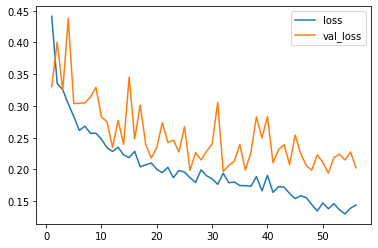

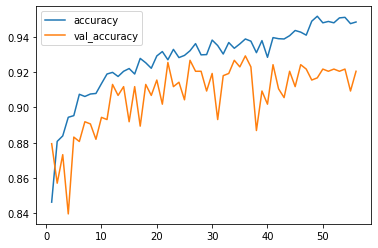

In [ ]:
history4 = final_model(fine_tune = 60, data = False, verbose = True)
print(f"Best Validation accuracy: {round(max(history4.history['val_accuracy']),3)}") #print best validation accuracy
print(f"Best Validation loss: {round(min(history4.history['val_loss']),3)}")  # print best validation loss
history_frame = pd.DataFrame(history4.history)
history_frame.to_csv(('fine_tune60.csv'))
files.download('fine_tune60.csv')

In [ ]:
model = tf.keras.models.load_model('/content/Models')

## 3. Results

 Fine Tuning | Validation Accuracy  | Validation Loss 
-------------------|------------------|-------------------
0     | 0.939 | 0.165  
20     | 0.937 | 0.181 
40   | 0.937 | 0.175 
60   | 0.929 | 0.194 

The model trained with no fine tuning achieved the highest vaidation accuracy at 0.939 and so this model was selected as the final model. In order to assess its ability to predict the class on unseen data the model was evaluated using the model.evaluate function which showed an accuracy of 0.9407 and a loss of 0.1898. 

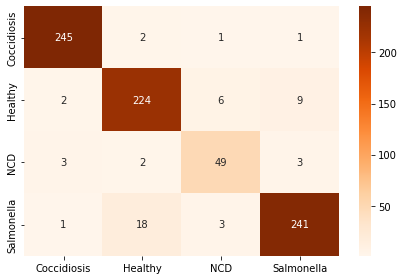

In [ ]:
# Load model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/content/Models')

# calculate loss and accuracy of model using test dataset
loss, accuracy = model.evaluate(ds_test_)

# create predictions of test dataset
pred = model.predict(ds_test_)

# create vector of maximum probability giving model classification
pred_class = np.argmax(pred, axis = 1)

# create vector of classes of actual classes
y = np.concatenate([y for x, y in ds_test_], axis=0)

# create vector of actual class
actual_class = np.argmax(y, axis = 1)

# Create tuple of class categories
classes = ('Coccidiosis', 'Healthy', 'NCD', 'Salmonella')

# calculate confusion matrix 
confm = confusion_matrix(actual_class, pred_class)#, normalize = 'pred', 'all', 'true'
df_cm = DataFrame(confm, index=columns, columns=classes)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label 
# being i-th class and predicted label being j-th class.

## 4. Discussion

## 5. Literature

Brodzicki, A., Piekarski, M., Kucharski, D., Jaworek-Korjakowska, J. and Gorgon, M. (2020). Transfer Learning Methods as a New Approach in Computer Vision Tasks with Small Datasets. Foundations of Computing and Decision Sciences, 45(3), pp.179–193. doi:10.2478/fcds-2020-0010.

Mikołajczyk, A. and Grochowski, M. (2018). Data augmentation for improving deep learning in image classification problem. [online] IEEE Xplore. doi:10.1109/IIPHDW.2018.8388338.

‌

Viloria, A., Pineda Lezama, O.B. and Mercado-Caruzo, N. (2020). Unbalanced data processing using oversampling: Machine Learning. Procedia Computer Science, [online] 175, pp.108–113. doi:10.1016/j.procs.2020.07.018.

‌
Quach, L.-D., Quoc, N.P., Thi, N.H., Le Thanh, N., Thanh, X.T.T., Tran, D.C. and Hassan, M.F. (2022). An AI-Based Chicken Disease Management System. International Conference on Artificial Intelligence for Smart Community, pp.707–716. doi:10.1007/978-981-16-2183-3_68.

‌